In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pyod.utils.data import generate_data_clusters
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pyod.utils.utility import standardizer
from pyod.models.combination import average, maximization

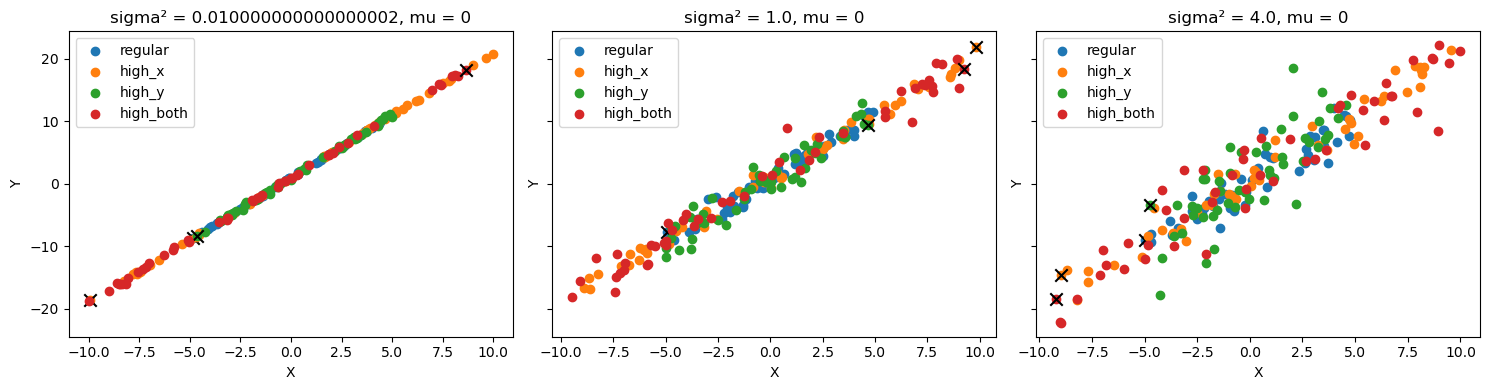

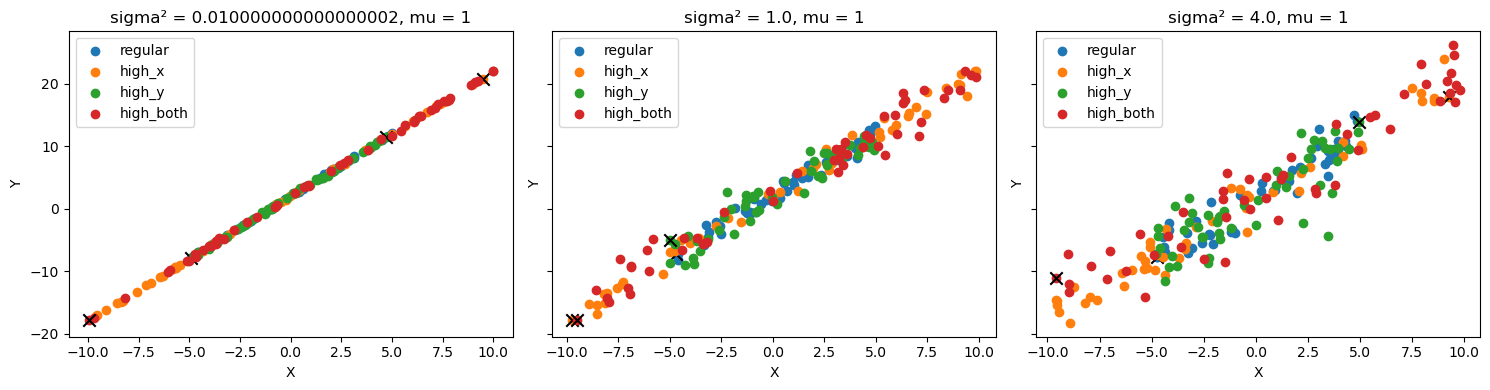

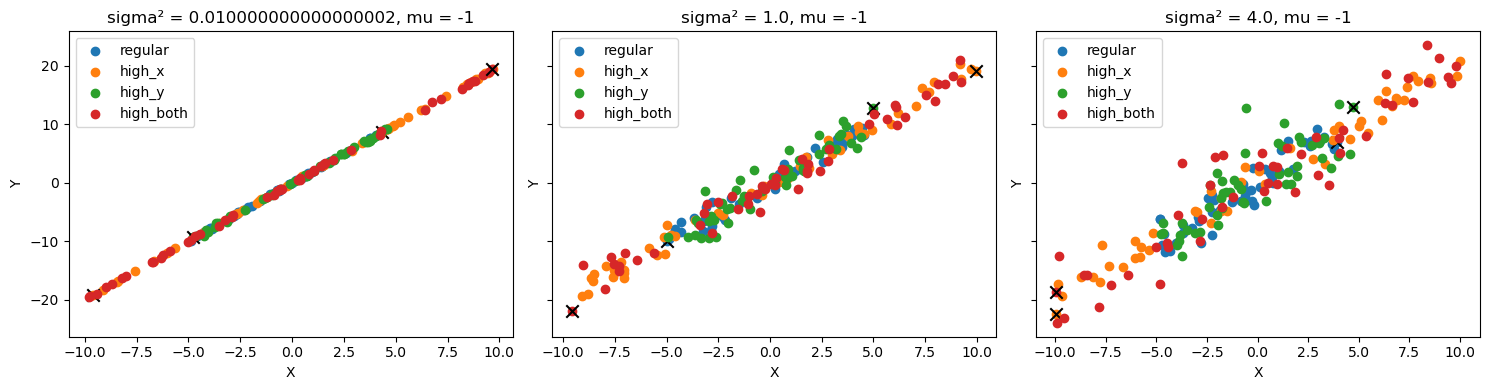

In [2]:
# Ex. 1
# In this exercise we verify numerically the purpose of the leverage scores discussed in class. Generate a random linear model y = ax1 + b + ϵ
# where ϵ is random Gaussian noise with mean µ and variance σ2. For various values of µ, σ2 generate data and compute the leverage scores for all
# the points. Create four types of points: regular (low noise, close to the model), high variance on x, high variance on y and finally high
# variance on both x and y. Plot all results, group in subplots for the various values of noise variance. Mark on the plots the points with the
# highest leverage scores. Repeat the exercise for the 2D case y = ax1+bx2+c+ϵ.

# computing leverage scores for a linear regression design matrix X_design
def hat_leverage(X_design):
    XtX_inv = np.linalg.inv(X_design.T @ X_design)  # inverse of X^T X
    H = X_design @ XtX_inv @ X_design.T
    return np.diag(H)                               # diagonal entries are the leverages

# setting the parameters
n_samples = 50
a, b = 2, 1
mus = [0, 1, -1]          # different values of µ
sigmas = [0.1, 1.0, 2.0]  # different values of σ
point_types = ['regular', 'high_x', 'high_y', 'high_both']

for mu in mus:
    fig, axes = plt.subplots(1, len(sigmas), figsize=(5*len(sigmas), 4), sharey=True)
    for i, sigma in enumerate(sigmas):
        ax = axes[i]
        
        for pt in point_types:
            # generate X
            if pt in ['regular', 'high_y']:
                X = np.random.uniform(-5, 5, size=n_samples)
            else:  # high_x or high_both
                X = np.random.uniform(-10, 10, size=n_samples)
            
            # generate noise
            if pt in ['regular', 'high_x']:
                eps = np.random.normal(mu, sigma, size=n_samples)
            else:  # high_y or high_both
                eps = np.random.normal(mu, 2*sigma, size=n_samples)
            
            # generate Y
            Y = a*X + b + eps
            
            # design matrix
            X_design = np.column_stack((np.ones(n_samples), X))
            leverages = hat_leverage(X_design)
            
            # find point with max leverage
            max_idx = np.argmax(leverages)
            
            # plot points
            ax.scatter(X, Y, label=pt)
            ax.scatter(X[max_idx], Y[max_idx], color='black', marker='x', s=80)  # mark highest leverage
        
        ax.set_title(f"sigma² = {sigma**2}, mu = {mu}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
    plt.tight_layout()
    plt.show()

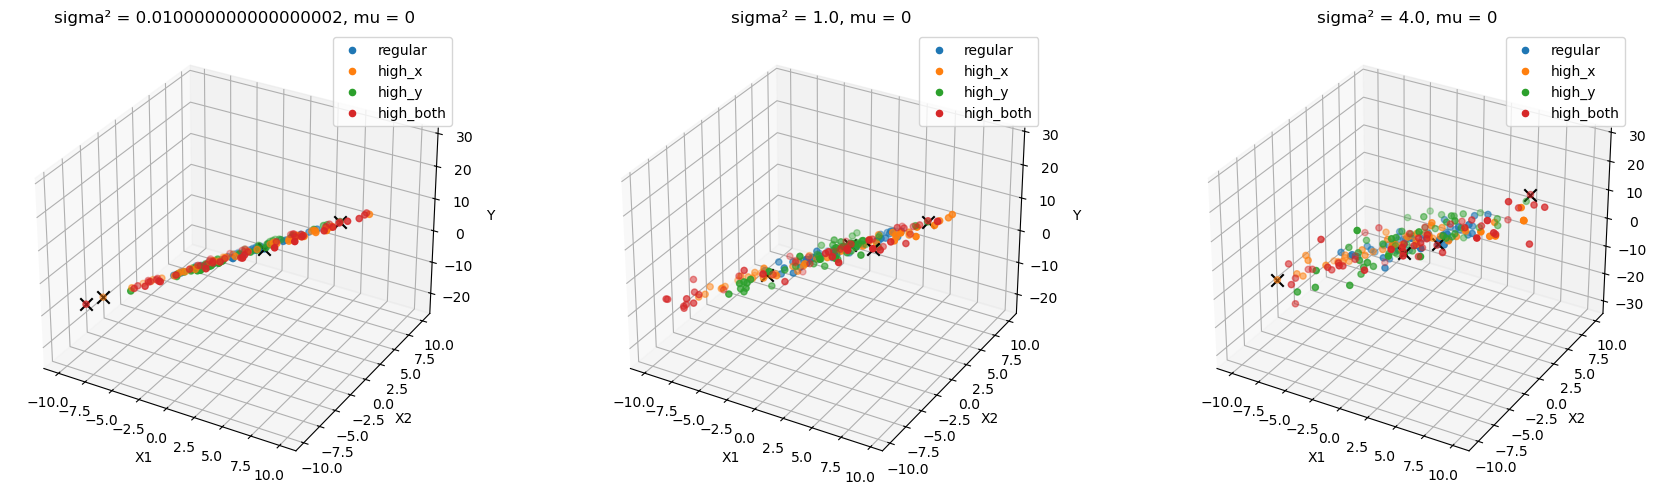

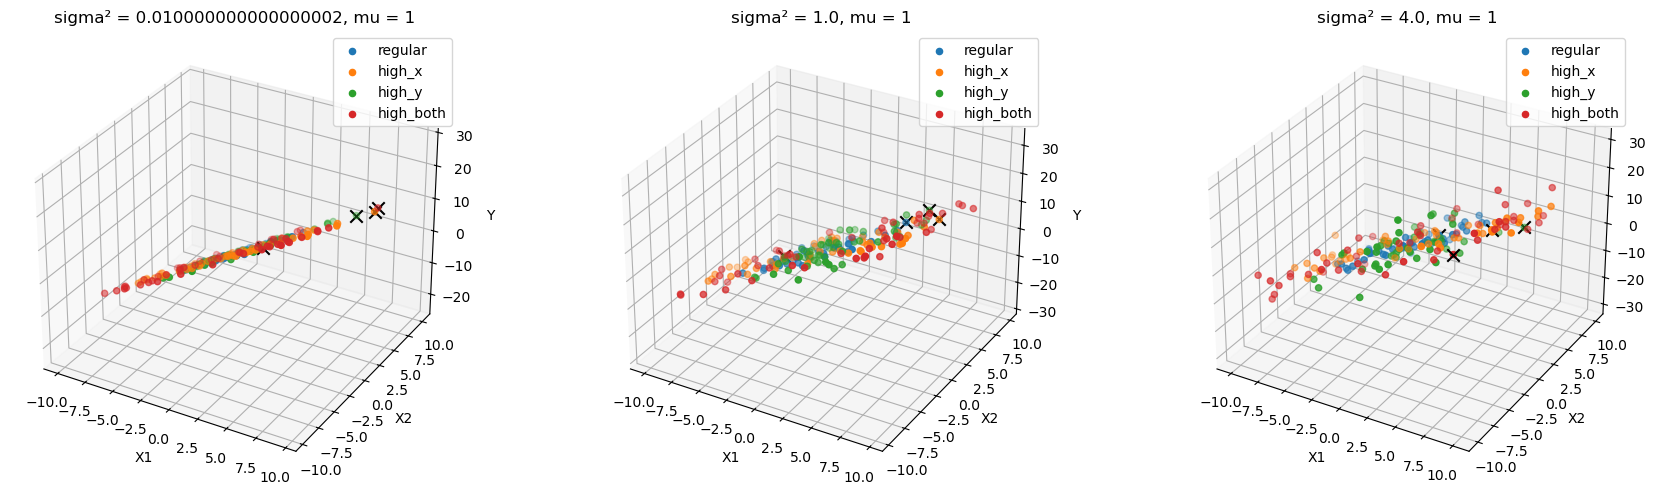

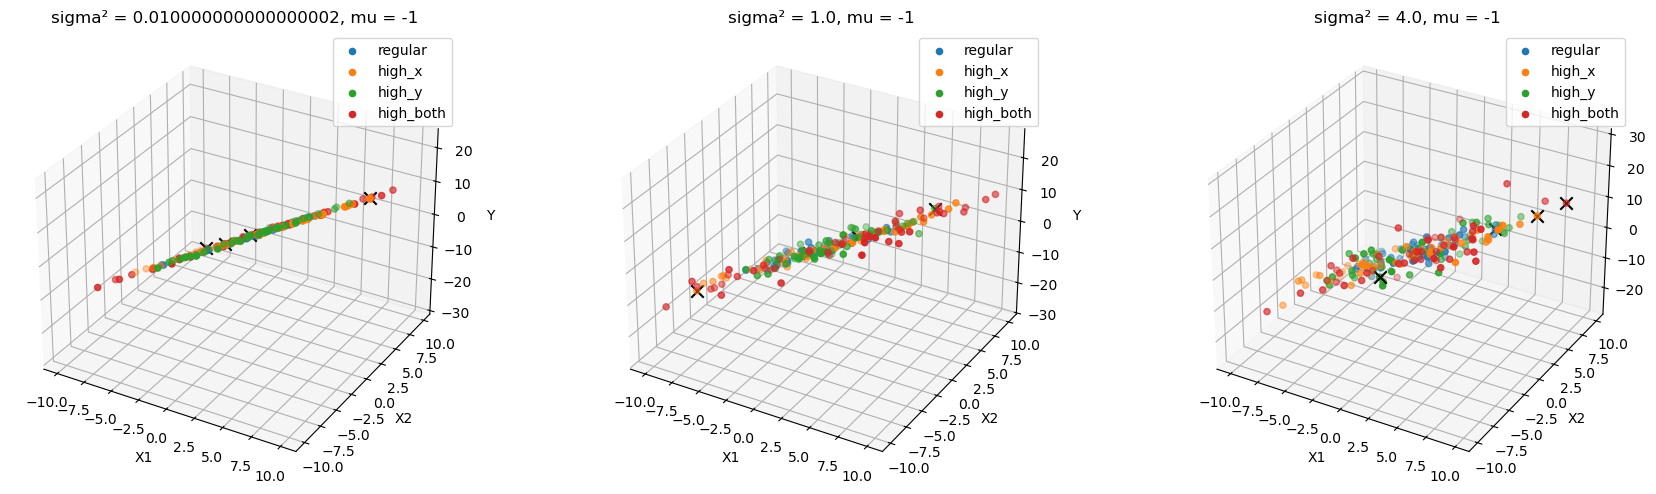

In [3]:
# computing leverage scores for a linear regression design matrix X_design
def hat_leverage(X_design):
    XtX_inv = np.linalg.inv(X_design.T @ X_design)
    H = X_design @ XtX_inv @ X_design.T
    return np.diag(H)

# parameters
n_samples = 50
a, b, c = 2, -1, 1
mus = [0, 1, -1]          # different values of µ
sigmas = [0.1, 1.0, 2.0]  # different values of σ
point_types = ['regular', 'high_x', 'high_y', 'high_both']

for mu in mus:
    fig = plt.figure(figsize=(18, 5))
    
    for i, sigma in enumerate(sigmas):
        ax = fig.add_subplot(1, len(sigmas), i+1, projection='3d')
        
        for pt in point_types:
            # generate X1, X2
            if pt in ['regular', 'high_y']:
                X1 = np.random.uniform(-5, 5, size=n_samples)
            else:  # high_x or high_both
                X1 = np.random.uniform(-10, 10, size=n_samples)
                
            if pt in ['regular', 'high_x']:
                X2 = np.random.uniform(-5, 5, size=n_samples)
            else:  # high_y or high_both
                X2 = np.random.uniform(-10, 10, size=n_samples)
            
            # generate noise
            if pt in ['regular', 'high_x']:
                eps = np.random.normal(mu, sigma, size=n_samples)
            else:  # high_y or high_both
                eps = np.random.normal(mu, 2*sigma, size=n_samples)
            
            # generate Y
            Y = a*X1 + b*X2 + c + eps
            
            # design matrix
            X_design = np.column_stack((np.ones(n_samples), X1, X2))
            leverages = hat_leverage(X_design)
            
            # find point with max leverage
            max_idx = np.argmax(leverages)
            
            # plot points
            ax.scatter(X1, X2, Y, label=pt)
            ax.scatter(X1[max_idx], X2[max_idx], Y[max_idx], color='black', marker='x', s=80)
        
        ax.set_title(f"sigma² = {sigma**2}, mu = {mu}")
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_zlabel("Y")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

Training data shape: (400, 2)
Test data shape: (200, 2)

KNN with n_neighbors = 5
Balanced Accuracy - Train: 0.988
Balanced Accuracy - Test:  1.000


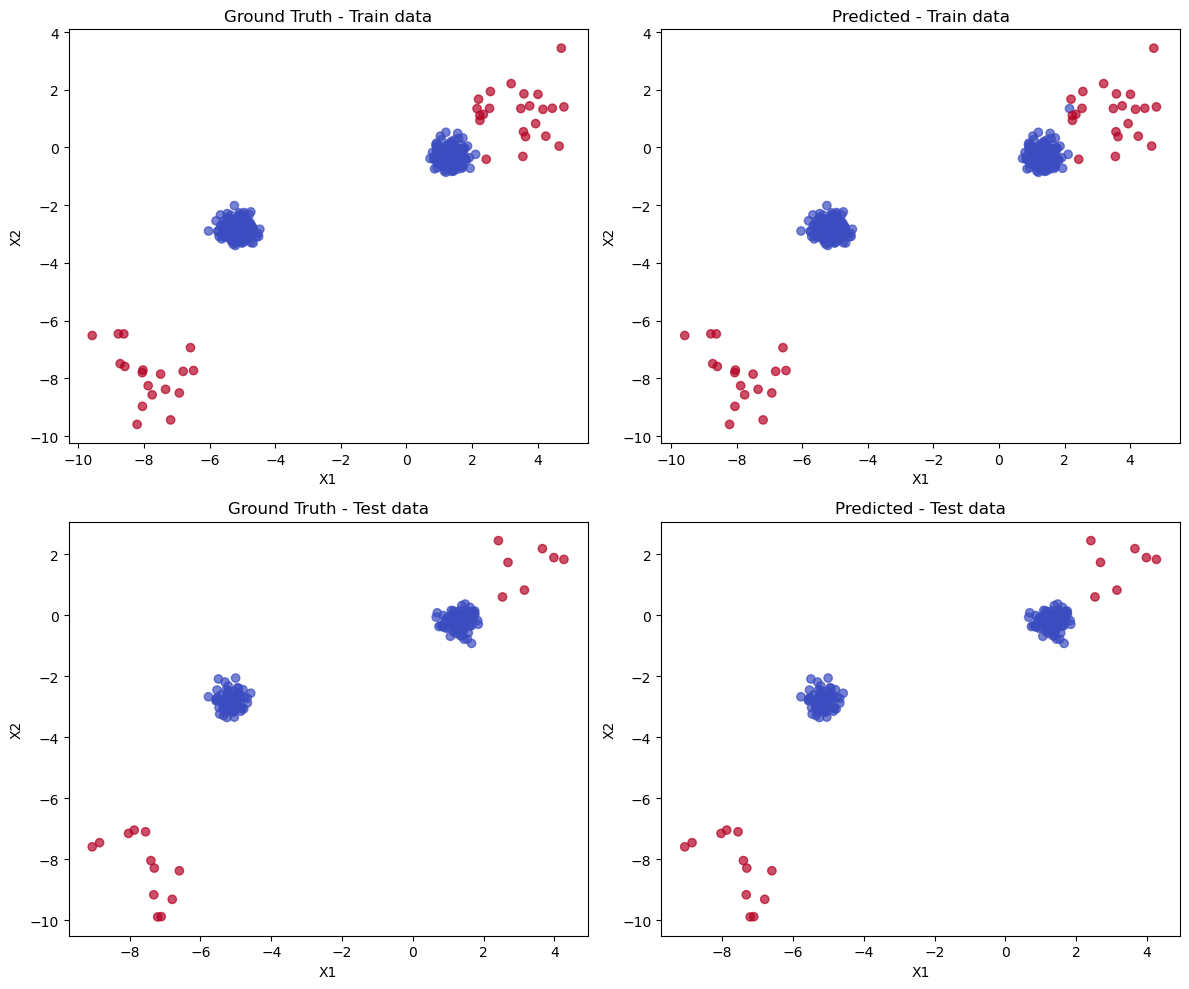


KNN with n_neighbors = 10
Balanced Accuracy - Train: 0.988
Balanced Accuracy - Test:  1.000


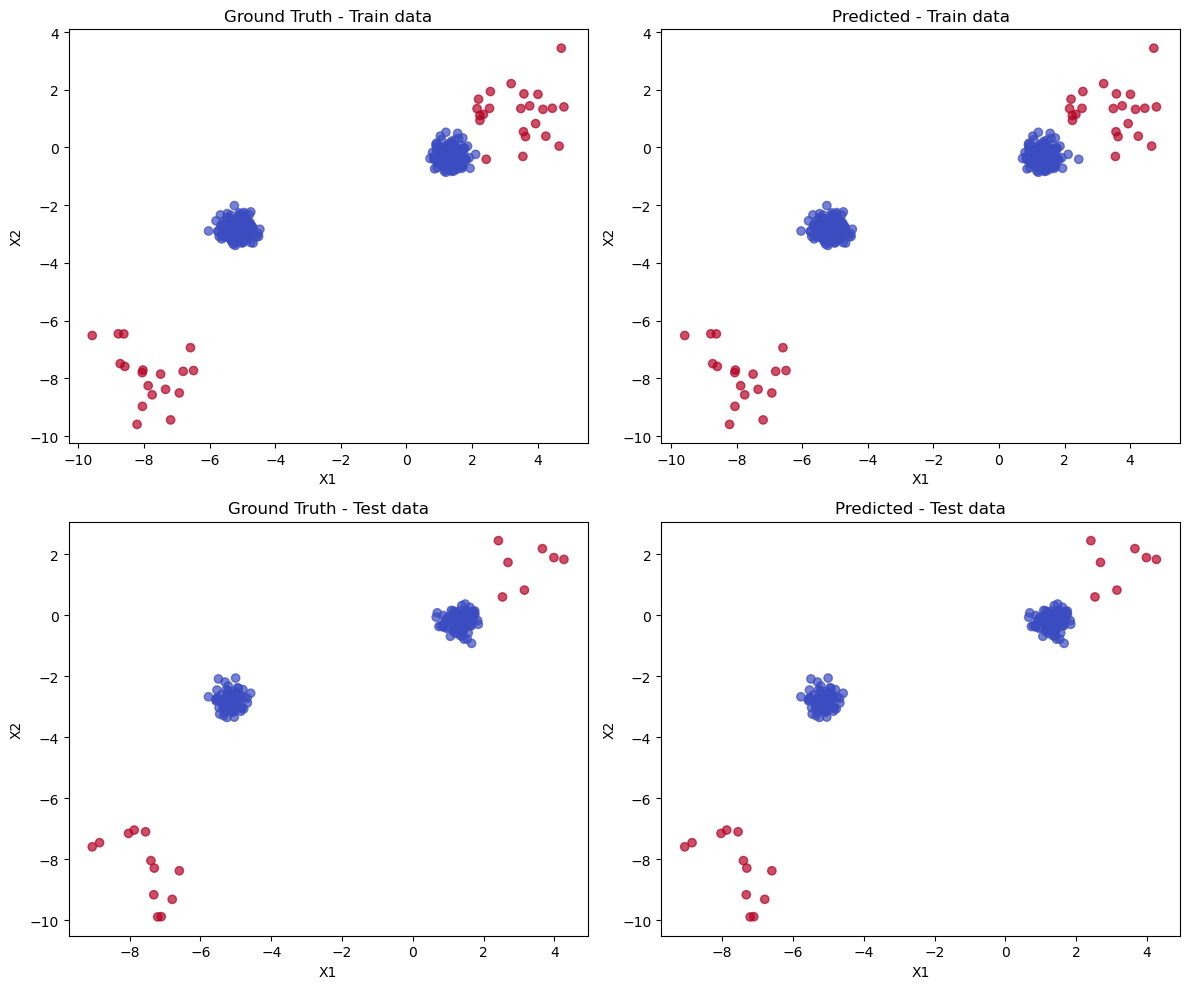


KNN with n_neighbors = 20
Balanced Accuracy - Train: 0.988
Balanced Accuracy - Test:  1.000


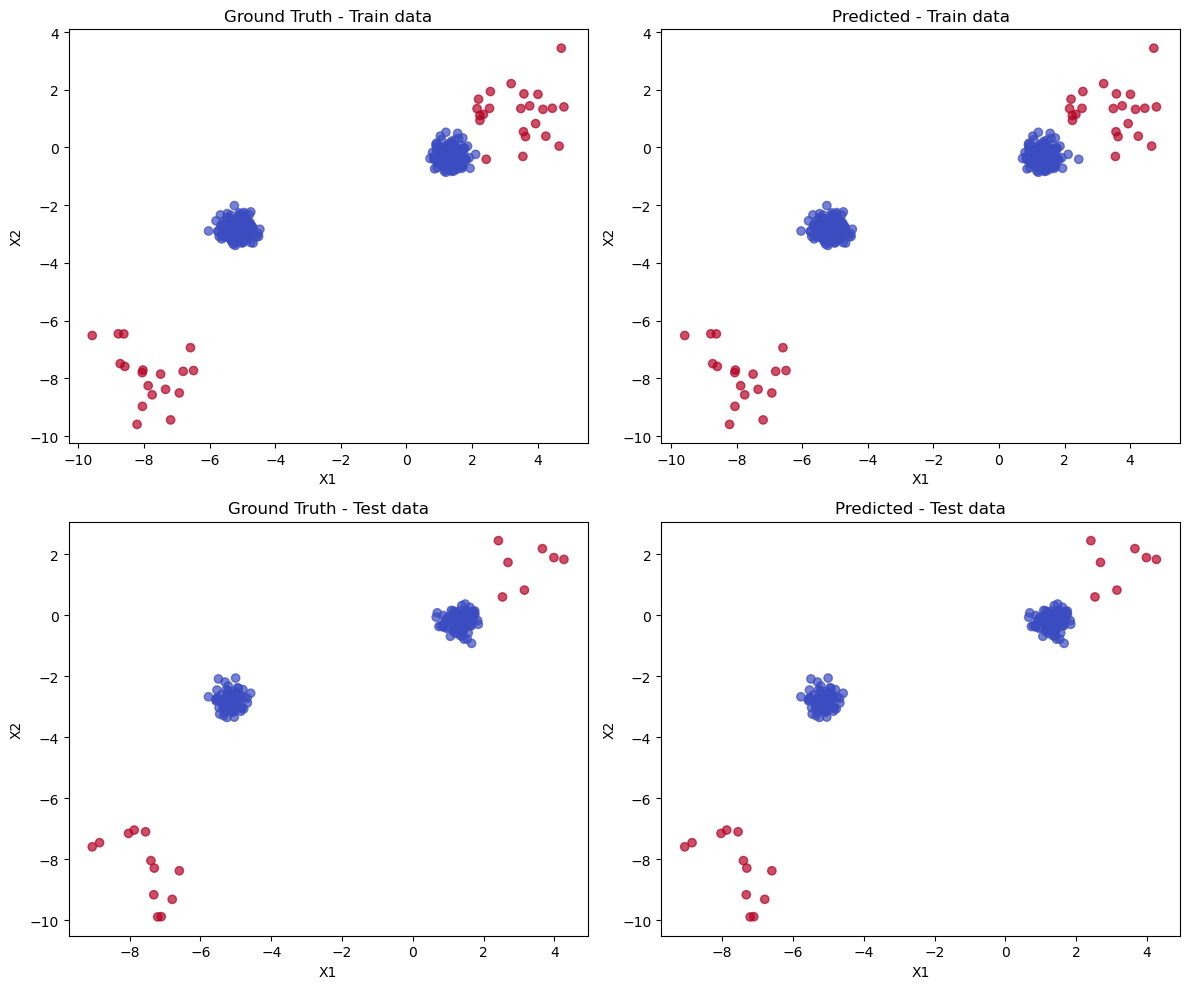

In [18]:
# Ex. 2
# Using the function generate data clusters generate a 2-dimensional dataset with 400 train samples and 200 test samples that are organized
# in 2 clusters, with 0.1 contamination. Train a KNN model from pyod.models.knn. Use 4 subplots in order to display using different colors 
# (for inliers and outliers):
# • Ground truth labels for training data
# • Predicted labels for training data
# • Ground truth labels for test data
# • Predicted labels for test data
# Use different values for the n neighbors parameter and observe how this affects the detection of small clusters of anomalies. 
# Also compute the balanced accuracy for each parameter.

# using the generate_data_clusters() function to generate a 2-dimensional dataset
# 400 train samples, 200 test samples organized in 2 clusters, 0.1 contamination
train_data, test_data, train_label, test_label = generate_data_clusters(n_train=400,n_test=200,n_clusters=2,n_features=2,contamination=0.1,random_state=42)

print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

neighbors_list = [5, 10, 20]  # different k values to try

for k in neighbors_list:
    print(f"\nKNN with n_neighbors = {k}")
    
    # train KNN
    clf = KNN(n_neighbors=k, contamination=0.1)
    clf.fit(train_data)
    
    # predictions
    train_label_pred = clf.labels_        # 0 = inlier, 1 = outlier
    test_label_pred = clf.predict(test_data)
    
    # balanced accuracy
    ba_train = balanced_accuracy_score(train_label, train_label_pred)
    ba_test = balanced_accuracy_score(test_label, test_label_pred)
    
    print(f"Balanced Accuracy - Train: {ba_train:.3f}")
    print(f"Balanced Accuracy - Test:  {ba_test:.3f}")

    # making 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Ground truth labels for training data
    axes[0, 0].scatter(train_data[:, 0], train_data[:, 1], c=train_label, cmap='coolwarm', alpha=0.7)
    axes[0, 0].set_title("Ground Truth - Train data")

    # Predicted labels for training data
    axes[0, 1].scatter(train_data[:, 0], train_data[:, 1], c=train_label_pred, cmap='coolwarm', alpha=0.7)
    axes[0, 1].set_title("Predicted - Train data")

    # Ground truth labels for test data
    axes[1, 0].scatter(test_data[:, 0], test_data[:, 1], c=test_label, cmap='coolwarm', alpha=0.7)
    axes[1, 0].set_title("Ground Truth - Test data")

    # Predicted labels for test data
    axes[1, 1].scatter(test_data[:, 0], test_data[:, 1], c=test_label_pred, cmap='coolwarm', alpha=0.7)
    axes[1, 1].set_title("Predicted - Test data")

    for ax in axes.flatten():
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")

    plt.tight_layout()
    plt.show()


Results for n_neighbors = 5


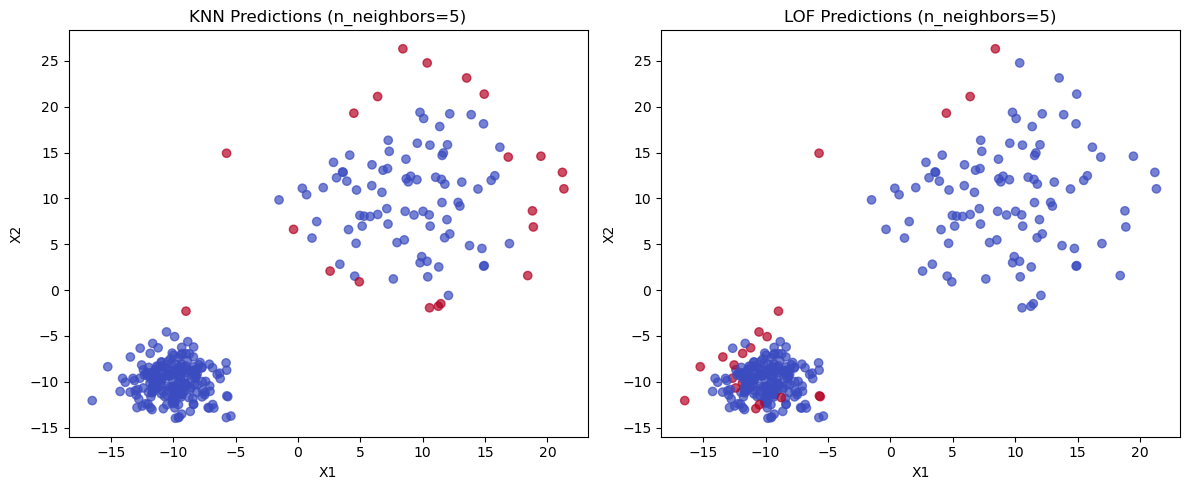


Results for n_neighbors = 15


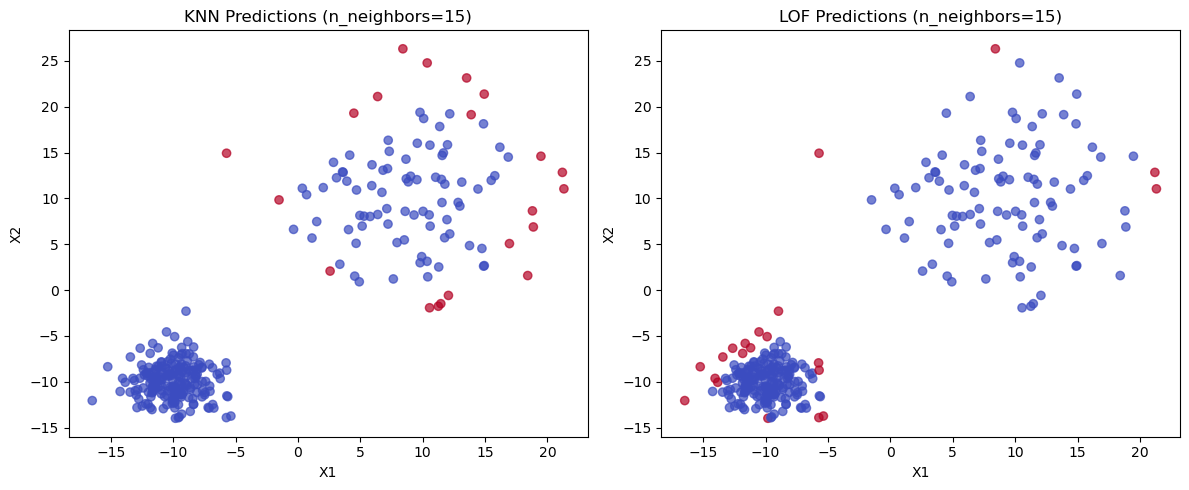

In [17]:
# Ex. 3
# In this exercise we will see the limitations of distance based algorithms like KNN. Specifically, we will observe how KNN behaves
# when our data clusters have different densities and how pyod.models.lof.LOF solves the problem by considering the variations of the
# local densities of the datapoints. First, generate 2 clusters (200 and 100 samples respectively) with 2-dimensional samples using
# (-10, -10) and (10, 10) as centers, 2 and 6 as standard deviations using sklearn.datasets.make blobs() function. Then, fit KNN and LOF
# with the generated data using a small contamination rate (0.07) and find the predicted labels. Use 2 subplots to plot (using different
# colors for inliers and outliers) the 2 clusters and observe how the 2 models behave for different n neighbors.

# using the sklearn.datasets.make blobs() function to generate 2 clusters - 200 and 100 samples respectively 
# 2-dimensional samples, (-10, -10) and (10, 10) as centers, 2 and 6 as standard deviations 
X1, _ = make_blobs(n_samples=200, n_features=2, centers=[(-10, -10)], cluster_std=2, random_state=42)
X2, _ = make_blobs(n_samples=100, n_features=2, centers=[(10, 10)], cluster_std=6, random_state=42)

# combine clusters
X = np.vstack([X1, X2])

neighbors_list = [5, 15]

for neighbors in neighbors_list:
    print(f"\nResults for n_neighbors = {neighbors}")
    
    # fitting KNN with the generated data using a 0.07 contamination rate and finding the predicted labels
    knn = KNN(contamination=0.07, n_neighbors=neighbors)
    knn.fit(X)
    knn_pred = knn.labels_  # 0 = inlier, 1 = outlier
    
    # fitting LOF with the generated data using a 0.07 contamination rate and finding the predicted labels
    lof = LOF(contamination=0.07, n_neighbors=neighbors)
    lof.fit(X)
    lof_pred = lof.labels_  # 0 = inlier, 1 = outlier

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # KNN plot
    axes[0].scatter(X[:, 0], X[:, 1], c=knn_pred, cmap='coolwarm', alpha=0.7)
    axes[0].set_title(f"KNN Predictions (n_neighbors={neighbors})")
    axes[0].set_xlabel("X1")
    axes[0].set_ylabel("X2")

    # LOF plot
    axes[1].scatter(X[:, 0], X[:, 1], c=lof_pred, cmap='coolwarm', alpha=0.7)
    axes[1].set_title(f"LOF Predictions (n_neighbors={neighbors})")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")

    plt.tight_layout()
    plt.show()

In [6]:
# Ex. 4
# For this exercise we will need the cardio dataset from ODDS (https://odds.cs. stonybrook.edu/cardiotocogrpahy-dataset/). 
# Load the data using scipy.io.loadmat() and use train test split() to split it into train and test subsets. Normalize your data
# accordingly. You will use an ensemble of classifiers of the same type (KNN or LOF) in order to create an average/maximization
# strategy (average/maximum score will be returned). Create 10 KNN/LOF models for which you vary parameter n neighbors from 30 to 120
# (here you can use other intervals/steps if you observe that they produce better results). Fit each model, print the balanced accuracy
# (BA) for train/test data and store both the train and test scores in order to use them later. Normalize both scores using
# pyod.utils.utility.standardizer() and use pyod.models.combination.average() and pyod.models.combination.maximization() to find
# the final scores for the 2 strategies. For each of them find the threshold used for classification (using numpy.quantile() with
# the known contamination rate of the dataset), compute the predictions and print the balanced accuracy (BA).

import scipy.io as sio

# loading the .mat file
data = sio.loadmat('cardio.mat')
X = data['X']
y = data['y'].ravel()
print("X shape:", X.shape)
print("y shape:", y.shape)

# using train_test_split() to split data into train and test subsets
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.3, random_state=42)
print("train_data shape:", train_data.shape, "test_data shape:", test_data.shape)

# normalizing data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

neighbors_list = np.linspace(30, 120, 10, dtype=int)  # 10 values from 30 to 120
train_scores_list = []
test_scores_list = []

for n in neighbors_list:
    model = KNN(contamination=0.07, n_neighbors=n)
    model.fit(train_data_scaled)
    
    train_scores_list.append(model.decision_scores_)
    test_scores_list.append(model.decision_function(test_data_scaled))
    
    # compute predictions and BA for individual models
    train_pred = model.labels_
    test_pred = model.predict(test_data_scaled)
    
    print(f"n_neighbors={n} | Train BA={balanced_accuracy_score(train_label, train_pred):.3f} | Test BA={balanced_accuracy_score(test_label, test_pred):.3f}")

# converting lists to arrays
train_scores_arr = np.column_stack(train_scores_list)
test_scores_arr = np.column_stack(test_scores_list)

# using pyod.utils.utility.standardizer() to normalize both scores
train_scores_std, test_scores_std = standardizer(train_scores_arr, test_scores_arr)

# using pyod.models.combination.average() and pyod.models.combination.maximization() to find the final scores
train_avg_scores = average(train_scores_std)
test_avg_scores = average(test_scores_std)

train_max_scores = maximization(train_scores_std)
test_max_scores = maximization(test_scores_std)

contamination = 0.07

# finding the threshold used for classification
thresh_train_avg = np.quantile(train_avg_scores, 1 - contamination)
thresh_test_avg = np.quantile(test_avg_scores, 1 - contamination)

thresh_train_max = np.quantile(train_max_scores, 1 - contamination)
thresh_test_max = np.quantile(test_max_scores, 1 - contamination)

# computing the predictions
train_pred_avg = (train_avg_scores >= thresh_train_avg).astype(int)
test_pred_avg = (test_avg_scores >= thresh_test_avg).astype(int)

train_pred_max = (train_max_scores >= thresh_train_max).astype(int)
test_pred_max = (test_max_scores >= thresh_test_max).astype(int)

# printing Balanced Accuracy
print("Average Strategy | Train BA:", balanced_accuracy_score(train_label, train_pred_avg), 
      "| Test BA:", balanced_accuracy_score(test_label, test_pred_avg))
print("Maximization Strategy | Train BA:", balanced_accuracy_score(train_label, train_pred_max), 
      "| Test BA:", balanced_accuracy_score(test_label, test_pred_max))

X shape: (1831, 21)
y shape: (1831,)
train_data shape: (1281, 21) test_data shape: (550, 21)
n_neighbors=30 | Train BA=0.656 | Test BA=0.670
n_neighbors=40 | Train BA=0.670 | Test BA=0.686
n_neighbors=50 | Train BA=0.684 | Test BA=0.719
n_neighbors=60 | Train BA=0.689 | Test BA=0.728
n_neighbors=70 | Train BA=0.698 | Test BA=0.737
n_neighbors=80 | Train BA=0.698 | Test BA=0.744
n_neighbors=90 | Train BA=0.694 | Test BA=0.745
n_neighbors=100 | Train BA=0.694 | Test BA=0.745
n_neighbors=110 | Train BA=0.694 | Test BA=0.745
n_neighbors=120 | Train BA=0.694 | Test BA=0.745
Average Strategy | Train BA: 0.6983498594050614 | Test BA: 0.7127551020408164
Maximization Strategy | Train BA: 0.693610330028119 | Test BA: 0.7127551020408164
